<a href="https://colab.research.google.com/github/Patronus-Yichen-Li/EECS592-project/blob/main/Env_test_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wrds
!apt install swig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [ ]:
### install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install git+https://github.com/Phantom-eva/FinRL.git   # 删掉了<3.8版本限制

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Phantom-eva/FinRL.git to /tmp/pip-req-build-_rmj8rjo
  Running command git clone -q https://github.com/Phantom-eva/FinRL.git /tmp/pip-req-build-_rmj8rjo
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-0icbmfxi/pyfolio_06c2bc08c52c4af39d98484e617e2946
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-0icbmfxi/pyfolio_06c2bc08c52c4af39d98484e617e2946
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0icbmfxi/elegantrl_ccd76a9f6a1248f6b9039d22b9ee596f
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-0icbmfxi/elegantrl_ccd76a9f6a1248f6b9039d22b9ee596f
     |████████████████████████████████|

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 应该不需要
# !pip install stable-baselines3[extra]
# import stable_baselines3

### Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Create and Preprocess Dataset

In [ ]:
df = YahooDownloader(start_date = '2009-04-01',
                     end_date = '2022-11-01',
                     ticker_list = config_tickers.SP_500_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ADS: No data

In [ ]:
df.head(10)

,date,open,high,low,close,volume,tic,day
0,2009-04-01,10.815451,11.537911,10.743920,10.393170,5530768.0,A,2
1,2009-04-01,2.460000,2.700000,2.440000,2.451128,4184300.0,AAL,2
2,2009-04-01,40.520000,42.240002,40.400002,38.975742,1973000.0,AAP,2
3,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000.0,AAPL,2
4,2009-04-01,16.180000,16.420000,15.900000,13.337540,3438000.0,ABC,2
5,2009-04-01,4.840000,5.060000,4.780000,4.950000,407200.0,ABMD,2
6,2009-04-01,22.608175,22.612974,22.070801,16.309761,25387453.0,ABT,2
7,2009-04-01,27.260000,28.100000,27.080000,21.257452,8635200.0,ACN,2
8,2009-04-01,20.930000,22.180000,20.790001,21.959999,7287000.0,ADBE,2
9,2009-04-01,18.900000,19.190001,18.590000,13.535221,9714700.0,ADI,2


### Feature Engineering

In [ ]:
tech_indicators = [
    "rsi",
    "boll",
    "cci",
    "macd"
]

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3420, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,rsi,boll,cci,macd,vix,turbulence
0,2009-04-01,A,10.815451,11.537911,10.743920,10.393170,5530768.0,2.0,100.0,10.393170,66.666667,0.0,42.279999,0.0
1,2009-04-01,AAL,2.460000,2.700000,2.440000,2.451128,4184300.0,2.0,100.0,2.451128,66.666667,0.0,42.279999,0.0
2,2009-04-01,AAP,40.520000,42.240002,40.400002,38.975742,1973000.0,2.0,100.0,38.975742,66.666667,0.0,42.279999,0.0
3,2009-04-01,AAPL,3.717500,3.892857,3.710357,3.308904,589372000.0,2.0,100.0,3.308904,66.666667,0.0,42.279999,0.0
4,2009-04-01,ABC,16.180000,16.420000,15.900000,13.337540,3438000.0,2.0,100.0,13.337540,66.666667,0.0,42.279999,0.0
5,2009-04-01,ABMD,4.840000,5.060000,4.780000,4.950000,407200.0,2.0,100.0,4.950000,66.666667,0.0,42.279999,0.0
6,2009-04-01,ABT,22.608175,22.612974,22.070801,16.309761,25387453.0,2.0,100.0,16.309761,66.666667,0.0,42.279999,0.0
7,2009-04-01,ACN,27.260000,28.100000,27.080000,21.257452,8635200.0,2.0,100.0,21.257452,66.666667,0.0,42.279999,0.0
8,2009-04-01,ADBE,20.930000,22.180000,20.790001,21.959999,7287000.0,2.0,100.0,21.959999,66.666667,0.0,42.279999,0.0
9,2009-04-01,ADI,18.900000,19.190001,18.590000,13.535221,9714700.0,2.0,100.0,13.535221,66.666667,0.0,42.279999,0.0


In [ ]:
# the above code shoule run only once
def get_macd_ranking(processed_full, num, ascending, sort_label):
    rsi_average = processed_full.groupby("tic").mean().reset_index()
    rsi_average.sort_values(by=sort_label)
    if ascending:
        extreme_list = rsi_average.sort_values(by = sort_label)[0:num].get(['tic'])
    else:
        extreme_list = rsi_average.sort_values(by = sort_label)[-num:].get(['tic'])
    return extreme_list.values.tolist()

extreme_small_list = get_macd_ranking(processed_full, 100, True, 'macd')
extreme_large_list = get_macd_ranking(processed_full, 100, False, 'macd')
print(extreme_small_list)
print(extreme_large_list)

[['APA'], ['CCL'], ['NOV'], ['OI'], ['FTI'], ['NKTR'], ['KSS'], ['GPS'], ['MAC'], ['DISH'], ['GE'], ['WU'], ['HBI'], ['JWN'], ['XRX'], ['XRAY'], ['IVZ'], ['VNO'], ['AIV'], ['SLB'], ['T'], ['FLS'], ['NEM'], ['NWL'], ['F'], ['AAL'], ['M'], ['BEN'], ['KEY'], ['HBAN'], ['JNPR'], ['PPL'], ['HST'], ['FCX'], ['WBA'], ['MRO'], ['KIM'], ['HAL'], ['HPQ'], ['DXC'], ['MOS'], ['FE'], ['INTC'], ['PRGO'], ['TPR'], ['RF'], ['C'], ['JEF'], ['WDC'], ['BK'], ['AES'], ['EXC'], ['GLW'], ['VFC'], ['TAP'], ['CNP'], ['WY'], ['VZ'], ['BWA'], ['NI'], ['HP'], ['IPG'], ['HOG'], ['VTR'], ['CAG'], ['DAL'], ['BAC'], ['WMB'], ['PVH'], ['LEG'], ['CSX'], ['CMCSA'], ['NRG'], ['MGM'], ['LUV'], ['IP'], ['CSCO'], ['PNR'], ['OXY'], ['WFC'], ['PHM'], ['SLG'], ['USB'], ['UNM'], ['FITB'], ['UAL'], ['L'], ['DVN'], ['CPB'], ['HRB'], ['BSX'], ['EBAY'], ['ROL'], ['AIG'], ['SEE'], ['UDR'], ['BAX'], ['RCL'], ['MO'], ['PFE']]
[['AVY'], ['LH'], ['CDNS'], ['HON'], ['CAT'], ['CB'], ['VRSN'], ['AJG'], ['ITW'], ['EXR'], ['ILMN'], ['TFX'],

In [ ]:
temp_list = extreme_small_list
# temp_list = extreme_large_list
temp_2_list = np.reshape(temp_list,(len(temp_list))).tolist()
df_select = YahooDownloader(start_date = '2009-04-01',
                     end_date = '2022-11-01',
                     ticker_list = temp_2_list).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
processed_select = fe.preprocess_data(df_select)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3420, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker_select  = processed_select ["tic"].unique().tolist()
list_date_select  = list(pd.date_range(processed_select ['date'].min(),processed_select ['date'].max()).astype(str))
combination_select  = list(itertools.product(list_date_select ,list_ticker_select ))

processed_full_select  = pd.DataFrame(combination_select ,columns=["date","tic"]).merge(processed_select ,on=["date","tic"],how="left")
processed_full_select  = processed_full_select [processed_full_select ['date'].isin(processed_select ['date'])]
processed_full_select  = processed_full_select .sort_values(['date','tic'])

processed_full_select  = processed_full_select.fillna(0)

In [ ]:
train = data_split(processed_full_select , '2009-01-01','2020-07-01')
trade = data_split(processed_full_select , '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

283200
33700


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 100, State Space: 601


### Ensemble Method

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2020-07-01'
val_test_start = '2020-07-01'
val_test_end = '2021-10-31'

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "   ": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}


In [ ]:
ensemble_agent = DRLEnsembleAgent(df=processed_full_select,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)


In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  985.1485976474695
======Model training from:  2009-01-01 to  2020-07-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_4
-------------------------------------
| time/                 |           |
|    fps                | 27        |
|    iterations         | 100       |
|    time_elapsed       | 17        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -142      |
|    explained_variance | 0.0945    |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | -64.8     |
|    reward             | 1.2259066 |
|    std                | 1         |
|    value_loss         | 3.58      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 31   

In [ ]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value_ensemble=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ensemble)
perf_stats_all = pd.DataFrame(perf_stats_all)
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_ensemble, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_ensemble.loc[0,'date'],
             baseline_end = df_account_value_ensemble.loc[len(df_account_value_ensemble)-1,'date'])


NameError: ignored

### Other Methods

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    # "tech_indicator_list": config.INDICATORS,
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-5
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)

A2C

In [ ]:
A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}

model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=40000)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

df_account_value_A2C, df_actions_A2C = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cuda device
---------------------------------------
| time/                 |             |
|    fps                | 29          |
|    iterations         | 100         |
|    time_elapsed       | 33          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -142        |
|    explained_variance | -0.0639     |
|    learning_rate      | 0.0004      |
|    n_updates          | 99          |
|    policy_loss        | 77.6        |
|    reward             | 0.060737476 |
|    std                | 1           |
|    value_loss         | 0.339       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 31          |
|    iterations         | 200         |
|    time_elapsed       | 64          |
|    total_timesteps    | 2000        |
| train/                |             |
| 

DDPG

In [ ]:
DDPG_PARAMS = {"buffer_size": 10_000, "learning_rate": 0.0005, "batch_size": 64}

model_ddpg = agent.get_model(model_name="ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=40000)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

df_account_value_DDPG, df_actions_DDPG = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


KeyboardInterrupt: ignored

PPO

In [ ]:
PPO_PARAMS = {"n_steps": 2048, "ent_coef": 0.01, "learning_rate": 0.00025, "batch_size": 128}

model_ppo = agent.get_model(model_name="ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=50000)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

df_account_value_PPO, df_actions_PPO = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
----------------------------------
| time/              |           |
|    fps             | 30        |
|    iterations      | 1         |
|    time_elapsed    | 66        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2998374 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 131         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.052308984 |
|    clip_fraction        | 0.45        |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | -0.345      |
|    learning_rate        | 0.00025     |
|    loss                 | -1.46       

More complicated stats

==============Get Backtest Results===========
Annual return          0.354175
Cumulative returns     0.499992
Annual volatility      0.224956
Sharpe ratio           1.463802
Calmar ratio           3.107853
Stability              0.839230
Max drawdown          -0.113961
Omega ratio            1.277519
Sortino ratio          2.415882
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.191863
Daily value at risk   -0.027035
dtype: float64
==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.338540
Cumulative returns     0.475169
Annual volatility      0.142903
Sharpe ratio           2.119107
Calmar ratio           3.524821
Stability              0.957812
Max drawdown          -0.096045
Omega ratio            1.422496
Sortino ratio          3.082553
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.120

Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,35.418%
Cumulative returns,49.999%
Annual volatility,22.496%
Sharpe ratio,1.46
Calmar ratio,3.11
Stability,0.84
Max drawdown,-11.396%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.40,2020-08-10,2020-09-23,2020-11-09,66
1,10.09,2021-06-08,2021-07-19,NaT,NaN
2,6.43,2021-03-15,2021-03-24,2021-04-16,25
3,6.14,2021-01-14,2021-01-29,2021-02-16,24
4,6.09,2020-12-04,2020-12-22,2021-01-06,24


Stress Events,mean,min,max
New Normal,0.13%,-3.65%,9.08%


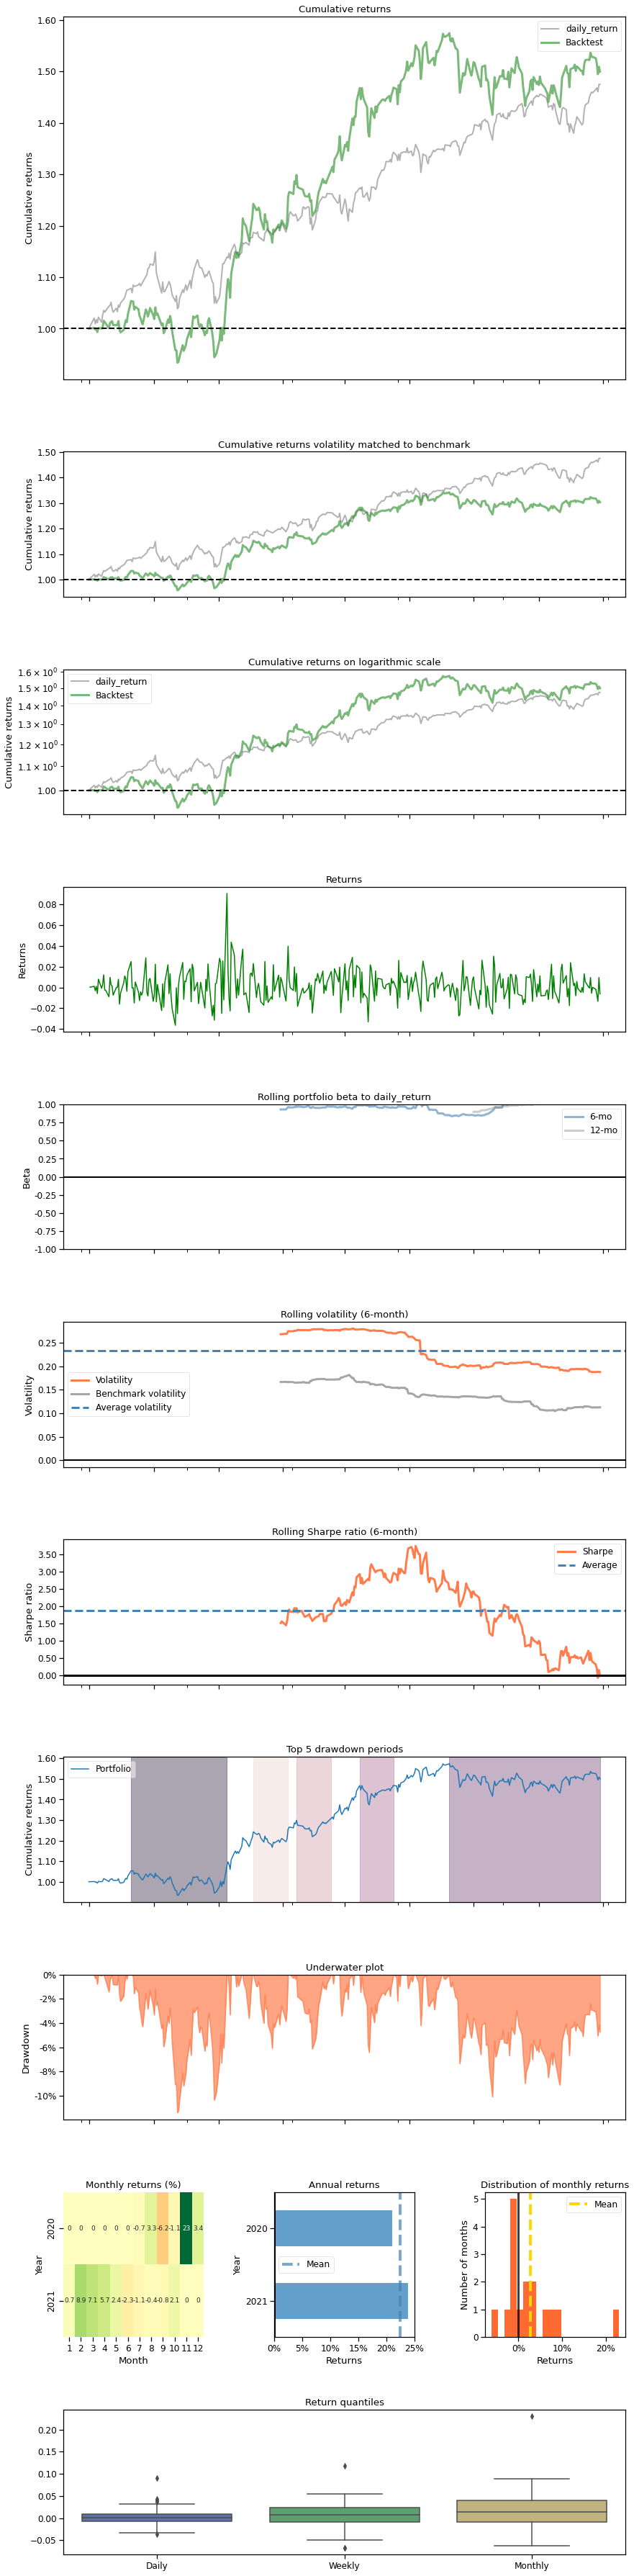

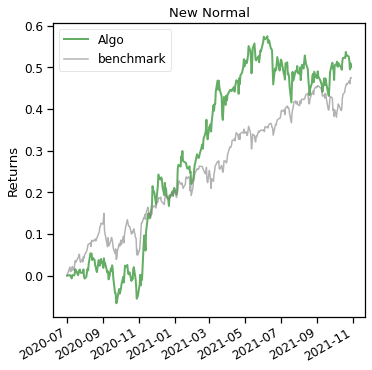

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_A2C)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = df_account_value_A2C.loc[0,'date'],
        end = df_account_value_A2C.loc[len(df_account_value_A2C)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_A2C, 
             baseline_ticker = '^GSPC', 
             baseline_start = df_account_value_A2C.loc[0,'date'],
             baseline_end = df_account_value_A2C.loc[len(df_account_value_A2C)-1,'date'])


Plot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)


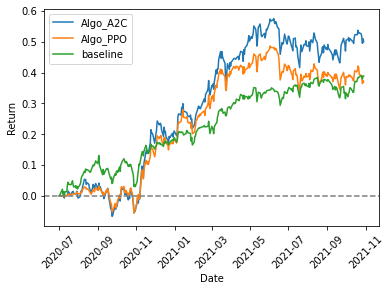

In [ ]:
df_account_value_A2C["date"] = pd.to_datetime(df_account_value_A2C["date"])
df_account_value_DDPG["date"] = pd.to_datetime(df_account_value_DDPG["date"])
df_account_value_PPO["date"] = pd.to_datetime(df_account_value_PPO["date"])
df_account_value_ensemblep["date"] = pd.to_datetime(df_account_value_ensemble["date"])

df_baseline = YahooDownloader(start_date=df_account_value_A2C.loc[0,'date'], 
                              end_date=df_account_value_A2C.loc[len(df_account_value_A2C)-1,'date'], 
                              ticker_list=['^DJI']).fetch_data()
# print(df_baseline)
df_baseline["date"] = pd.to_datetime(df_baseline["date"], format="%Y-%m-%d")
df_baseline = pd.merge(df_account_value_A2C[["date"]], df_baseline, how="left", on="date")
df_baseline = df_baseline.fillna(method="ffill").fillna(method="bfill")

from copy import deepcopy

def get_accumulative_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    init = df.loc[0, value_col_name]
    df["accumulative_return"] = df[value_col_name].apply(lambda x: (x - init)/init)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["accumulative_return"], index=df.index)

def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

baseline_returns = get_accumulative_return(df_baseline, value_col_name="close")
account_A2C_returns = get_accumulative_return(df_account_value_A2C, value_col_name="account_value")
account_DDPG_returns = get_accumulative_return(df_account_value_DDPG, value_col_name="account_value")
account_PPO_returns = get_accumulative_return(df_account_value_PPO, value_col_name="account_value")
account_ensemble_returns = get_accumulative_return(df_account_value_ensemble, value_col_name="account_value")

# plot
_, ax = plt.subplots()
ax.plot(account_A2C_returns, label="Algo_A2C")
ax.plot(account_DDPG_returns, label="Algo_DDPG")
ax.plot(account_PPO_returns, label="Algo_PPO")
ax.plot(account_ensemble_returns, label="ensemble")
ax.plot(baseline_returns, label="baseline")
plt.axhline(y=0.0, color="grey", linestyle="--")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Return")
plt.legend()
plt.show()

### Trading

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.tail()

,date,account_value
332,2021-10-25,1.435924e+06
333,2021-10-26,1.443075e+06
334,2021-10-27,1.454146e+06
335,2021-10-28,1.465477e+06
336,2021-10-29,1.472371e+06


### Testing Result

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.335485
Cumulative returns     0.472371
Annual volatility      0.145001
Sharpe ratio           2.074602
Calmar ratio           3.498489
Stability              0.962317
Max drawdown          -0.095894
Omega ratio            1.423147
Sortino ratio          3.054565
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.999909
Daily value at risk   -0.017075
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,33.548%
Cumulative returns,47.237%
Annual volatility,14.5%
Sharpe ratio,2.07
Calmar ratio,3.50
Stability,0.96
Max drawdown,-9.589%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.59,2020-09-02,2020-09-23,2020-12-28,84
1,5.74,2021-02-17,2021-03-04,2021-04-01,32
2,4.54,2021-09-01,2021-10-04,2021-10-15,33
3,3.84,2021-04-16,2021-05-12,2021-05-28,31
4,2.52,2021-06-14,2021-06-18,2021-06-28,11


Stress Events,mean,min,max
New Normal,0.12%,-3.92%,4.36%


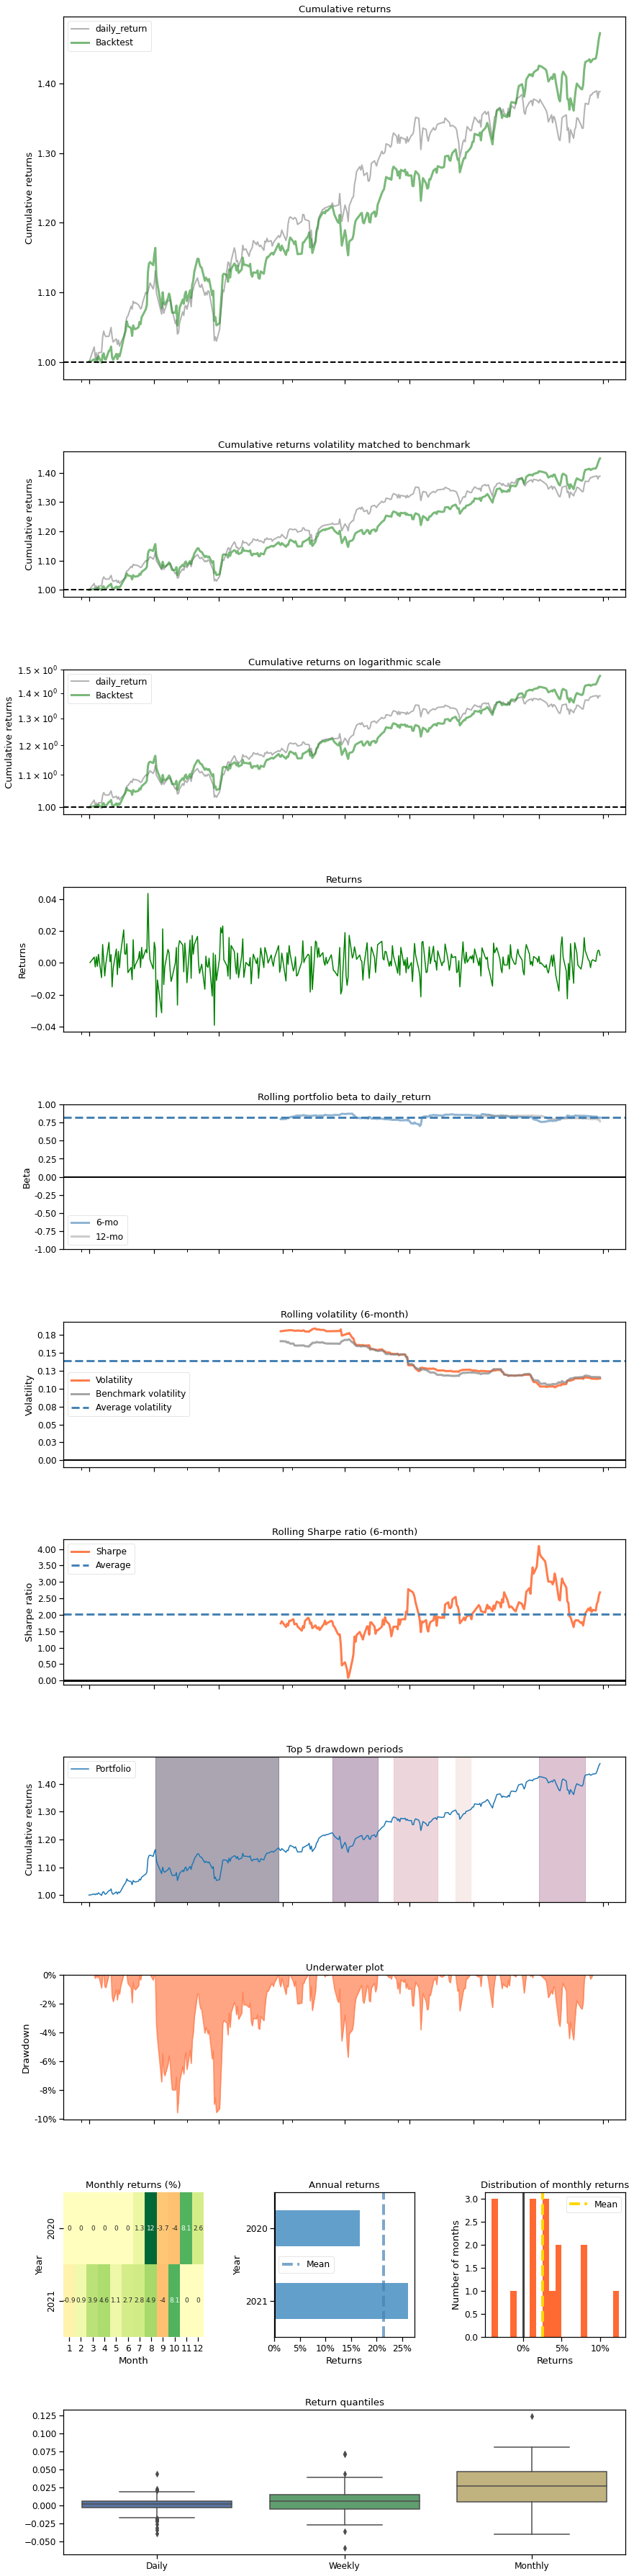

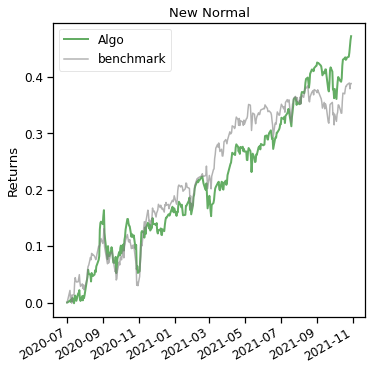

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])